In [2]:
%matplotlib inline
#from keras.models import Model
#from keras.layers import *
#from keras.optimizers import *
#from keras.utils import plot_model

#import tensorflow as tf
#import keras.initializers as kinit
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#from dqnroute.utils import *

from sklearn.model_selection import train_test_split
from cycler import cycler

In [4]:
target_cols = get_target_cols(10)
neighbors_cols = get_neighbors_cols(10)
addr_cols = get_addr_cols(10)
dst_cols = get_dst_cols(10)
amatrix_cols = get_amatrix_cols(10)
left_cols = ['time', 'pkg_id']+neighbors_cols+amatrix_cols+target_cols
new_cols = ['dst', 'addr'] + left_cols

In [5]:
data = pd.read_csv('logs/data_generated2_new.csv', names=new_cols)

In [6]:
import gc
gc.collect()

11

In [5]:
data.head()

,dst,addr,time,pkg_id,neighbors_0,neighbors_1,neighbors_2,neighbors_3,neighbors_4,neighbors_5,...,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5,predict_6,predict_7,predict_8,predict_9
0,0,1.0,10.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-10.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-30.0,-1000000.0,-30.0,-1000000.0
1,0,0.0,20.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1000000.0,-20.0,-20.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
2,1,2.0,20.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-20.0,-1000000.0,-1000000.0,-1000000.0
3,1,0.0,30.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,...,-1000000.0,-10.0,-30.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
4,1,1.0,40.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-20.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-20.0,-1000000.0,-20.0,-1000000.0


In [21]:
data.shape

(231072, 124)

In [6]:
from dqnroute.networks import *

# Feed-forward сети

In [7]:
tf.reset_default_graph()

ff_network_amatrix = FFNetworkAmatrix(10, activation='tanh')
ff_network_amatrix_64_3 = FFNetworkAmatrix(10, layers=[64, 64, 64], activation='tanh')
ff_network_amatrix_128_2 = FFNetworkAmatrix(10, layers=[128, 128], activation='tanh')
ff_network_amatrix_32_2 = FFNetworkAmatrix(10, layers=[32, 32], activation='tanh')
ff_network_amatrix_32_3 = FFNetworkAmatrix(10, layers=[32, 32, 32], activation='tanh')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [10]:
def shuffle(df):
    return df.reindex(np.random.permutation(df.index))

In [11]:
%%time
ff_network_amatrix_losses = ff_network_amatrix.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 18.35928629652613
Epoch 1... loss: 2.4398025982747398
Epoch 2... loss: 1.4162721513438927
Epoch 3... loss: 0.9567133855941866
Epoch 4... loss: 0.713304538863251
Epoch 5... loss: 0.5672282260502001
Epoch 6... loss: 0.4741966205073466
Epoch 7... loss: 0.4079173888906418
Epoch 8... loss: 0.35840067739566595
Epoch 9... loss: 0.3198429483075813
CPU times: user 5min 50s, sys: 7.23 s, total: 5min 57s
Wall time: 5min


In [12]:
%%time
ff_network_amatrix_64_3_losses = ff_network_amatrix_64_3.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 16.836515784857923
Epoch 1... loss: 1.8041205671029712
Epoch 2... loss: 0.8349385165001049
Epoch 3... loss: 0.4786408298948501
Epoch 4... loss: 0.3156055845026164
Epoch 5... loss: 0.23056221030123214
Epoch 6... loss: 0.18068864278669686
Epoch 7... loss: 0.15006248760757446
Epoch 8... loss: 0.12917691958107838
Epoch 9... loss: 0.11383773361973329
CPU times: user 6min 10s, sys: 8.39 s, total: 6min 18s
Wall time: 5min 12s


In [13]:
ff_network_amatrix_64_3.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64_64'

In [14]:
%%time
ff_network_amatrix_128_2_losses = ff_network_amatrix_128_2.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 11.342912123133447
Epoch 1... loss: 1.0356249634376145
Epoch 2... loss: 0.42708521173396874
Epoch 3... loss: 0.2384972932546394
Epoch 4... loss: 0.16029064324882417
Epoch 5... loss: 0.11961423758334308
Epoch 6... loss: 0.0962739755649606
Epoch 7... loss: 0.08121331210515535
Epoch 8... loss: 0.07026203959796455
Epoch 9... loss: 0.06253893920405512
CPU times: user 6min 28s, sys: 8.38 s, total: 6min 36s
Wall time: 5min 16s


In [46]:
ff_network_amatrix_128_2.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_tanh_128_128'

In [15]:
%%time
ff_network_amatrix_32_2_losses = ff_network_amatrix_32_2.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 33.95642717398694
Epoch 1... loss: 4.876535116247714
Epoch 2... loss: 3.782084513686235
Epoch 3... loss: 3.2410197062532653
Epoch 4... loss: 2.8619094535908594
Epoch 5... loss: 2.572697910051104
Epoch 6... loss: 2.337027454158306
Epoch 7... loss: 2.1565764326003265
Epoch 8... loss: 2.020667880451625
Epoch 9... loss: 1.913358991549065
CPU times: user 4min 44s, sys: 8.41 s, total: 4min 52s
Wall time: 3min 56s


In [16]:
ff_network_amatrix_32_2.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_tanh_32_32'

In [17]:
%%time
ff_network_amatrix_32_3_losses = ff_network_amatrix_32_3.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 32.7849481089791
Epoch 1... loss: 4.332442664494229
Epoch 2... loss: 2.8467106653570617
Epoch 3... loss: 2.1781808747477256
Epoch 4... loss: 1.789665062124421
Epoch 5... loss: 1.5149829605703389
Epoch 6... loss: 1.3105952059516053
Epoch 7... loss: 1.1565390199468235
Epoch 8... loss: 1.0307644755287921
Epoch 9... loss: 0.928927910243717
CPU times: user 4min 33s, sys: 9.13 s, total: 4min 43s
Wall time: 3min 40s


In [18]:
ff_network_amatrix_32_3.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_tanh_32_32_32'

In [19]:
losses_layers = np.array([ff_network_amatrix_losses,
                          ff_network_amatrix_32_2_losses,
                          ff_network_amatrix_32_3_losses,
                          ff_network_amatrix_64_3_losses,
                          ff_network_amatrix_128_2_losses]).transpose()

losses_layers_df = pd.DataFrame(data=losses_lay/sers, columns=['64x2', '32x2', '32x3', '64x3', '128x2'])
losses_layers_df.to_csv('logs/pre_train_data/layers_comparison.csv')

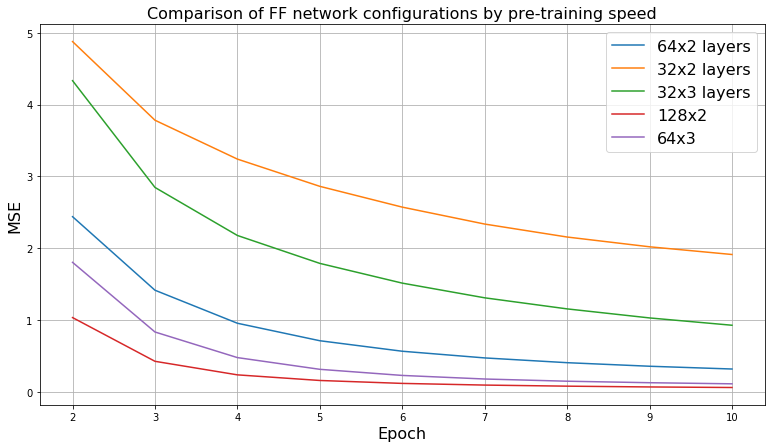

In [20]:
losses_layers_df = pd.read_csv('logs/pre_train_data/layers_comparison.csv')

ff_network_amatrix_losses = losses_layers_df['64x2']
ff_network_amatrix_32_2_losses = losses_layers_df['32x2']
ff_network_amatrix_32_3_losses = losses_layers_df['32x3']
ff_network_amatrix_64_3_losses = losses_layers_df['64x3']
ff_network_amatrix_128_2_losses = losses_layers_df['128x2']

x = range(2, 11)
fsize = 16
plt.figure(figsize=(13, 7))
plt.plot(x, ff_network_amatrix_losses[1:], label='64x2 layers')
plt.plot(x, ff_network_amatrix_32_2_losses[1:], label='32x2 layers')
plt.plot(x, ff_network_amatrix_32_3_losses[1:], label='32x3 layers')
plt.plot(x, ff_network_amatrix_128_2_losses[1:], label='128x2')
plt.plot(x, ff_network_amatrix_64_3_losses[1:], label='64x3')
plt.legend(prop={'size': fsize})
plt.xlabel('Epoch', fontsize=fsize)
plt.xticks(x)
plt.grid()
plt.ylabel('MSE', fontsize=fsize)
plt.title('Comparison of FF network configurations by pre-training speed', fontsize=fsize)
plt.show()

### tf.reset_default_graph()

ff_network_simple = FFNetwork(10)
ff_network_amatrix = FFNetworkAmatrix(10)
ff_network_amatrix_tr = FFNetworkAmatrixTriangle(10)

ff_network_amatrix_adam = FFNetworkAmatrix(10, optimizer='adam')
ff_network_amatrix_adagrad = FFNetworkAmatrix(10, optimizer='adagrad')
ff_network_amatrix_adadelta = FFNetworkAmatrix(10, optimizer='adadelta')

In [10]:
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [8]:
data_full_network = data[data['pkg_id'] < 5000]

In [26]:
ff_network_simple_losses = ff_network_simple.preTrain(sess, shuffle(data_full_network), epochs=20)

Epoch 0... loss: 78.62262120980483
Epoch 1... loss: 14.871742471364827
Epoch 2... loss: 4.260363800938313
Epoch 3... loss: 0.8365916058994256
Epoch 4... loss: 0.28186956027952526
Epoch 5... loss: 0.1647236649878323
Epoch 6... loss: 0.12434248215733812
Epoch 7... loss: 0.10642319223485314
Epoch 8... loss: 0.09659994973872717
Epoch 9... loss: 0.09093777423437971
Epoch 10... loss: 0.08589388681933857
Epoch 11... loss: 0.08302899016640507
Epoch 12... loss: 0.08044574869295153
Epoch 13... loss: 0.07823737811727019
Epoch 14... loss: 0.07608946208627178
Epoch 15... loss: 0.07424916666036901
Epoch 16... loss: 0.07282610023752428
Epoch 17... loss: 0.07133147623031759
Epoch 18... loss: 0.069781496307741
Epoch 19... loss: 0.06859436953225388


In [27]:
ff_network_simple.save(sess)

'../tf_models/dqn_rmsprop_ff_relu_64_64'

In [28]:
ff_network_amatrix_losses = ff_network_amatrix.preTrain(sess, shuffle(data), epochs=20)

Epoch 0... loss: 20.447906135786372
Epoch 1... loss: 4.643661883230306
Epoch 2... loss: 3.303941338870552
Epoch 3... loss: 2.512625103932209
Epoch 4... loss: 1.979670456490545
Epoch 5... loss: 1.5798248242405772
Epoch 6... loss: 1.298530455070459
Epoch 7... loss: 1.0862983740229568
Epoch 8... loss: 0.9365235086566044
Epoch 9... loss: 0.8269598113831812
Epoch 10... loss: 0.7394502467683867
Epoch 11... loss: 0.662241900987431
Epoch 12... loss: 0.6033494135045292
Epoch 13... loss: 0.558769474823114
Epoch 14... loss: 0.5240698578577757
Epoch 15... loss: 0.494669383216591
Epoch 16... loss: 0.4690791726640644
Epoch 17... loss: 0.44661703671532116
Epoch 18... loss: 0.42604318502792576
Epoch 19... loss: 0.40814511780881796


In [29]:
ff_network_amatrix.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_relu_64_64'

In [30]:
ff_network_amatrix_tr_losses = ff_network_amatrix_tr.preTrain(sess, shuffle(data), epochs=20)

Epoch 0... loss: 17.73343786087546
Epoch 1... loss: 3.965088716290892
Epoch 2... loss: 2.9608694781409852
Epoch 3... loss: 2.3558959019611687
Epoch 4... loss: 1.9409874854094764
Epoch 5... loss: 1.6296584677446946
Epoch 6... loss: 1.3909740541561078
Epoch 7... loss: 1.1945236260137173
Epoch 8... loss: 1.0377609800341518
Epoch 9... loss: 0.9219173991833676
Epoch 10... loss: 0.8369315630667198
Epoch 11... loss: 0.7637257822669951
Epoch 12... loss: 0.7040777457559427
Epoch 13... loss: 0.652798731944317
Epoch 14... loss: 0.6088730448287142
Epoch 15... loss: 0.5713581746304041
Epoch 16... loss: 0.5407442001940851
Epoch 17... loss: 0.5126001889678253
Epoch 18... loss: 0.4848593620485653
Epoch 19... loss: 0.46057583310154726


In [31]:
ff_network_amatrix_tr.save(sess)

'../tf_models/dqn_rmsprop_amatrix_tr_ff_relu_64_64'

In [32]:
ff_network_amatrix_adam_losses = ff_network_amatrix_adam.preTrain(sess, shuffle(data), epochs=20)

Epoch 0... loss: 18.251712229208607
Epoch 1... loss: 4.522735943367996
Epoch 2... loss: 3.1688380884160097
Epoch 3... loss: 2.347656447510032
Epoch 4... loss: 1.8067276861393258
Epoch 5... loss: 1.4408513568037353
Epoch 6... loss: 1.1705549874888153
Epoch 7... loss: 0.9539229440575177
Epoch 8... loss: 0.7906851241742453
Epoch 9... loss: 0.655029917663855
Epoch 10... loss: 0.5521822214011026
Epoch 11... loss: 0.4741663847883691
Epoch 12... loss: 0.41776333243715486
Epoch 13... loss: 0.37288195718987266
Epoch 14... loss: 0.33720442236683207
Epoch 15... loss: 0.30859404751351793
Epoch 16... loss: 0.2863175475833456
Epoch 17... loss: 0.26862353909120484
Epoch 18... loss: 0.25449410466078226
Epoch 19... loss: 0.2421659543561384


In [33]:
ff_network_amatrix_adam.save(sess)

'../tf_models/dqn_adam_amatrix_ff_relu_64_64'

In [34]:
ff_network_amatrix_adagrad_losses = ff_network_amatrix_adagrad.preTrain(sess, shuffle(data), epochs=20)

Epoch 0... loss: 129.6132658316709
Epoch 1... loss: 79.7928481372072
Epoch 2... loss: 63.463012115527114
Epoch 3... loss: 55.79988768054184
Epoch 4... loss: 50.26219939815752
Epoch 5... loss: 46.31411260846017
Epoch 6... loss: 43.65559214275145
Epoch 7... loss: 41.901402938730776
Epoch 8... loss: 40.69410583930338
Epoch 9... loss: 39.69435130326541
Epoch 10... loss: 38.87582319275756
Epoch 11... loss: 38.138846371910475
Epoch 12... loss: 37.46851772291973
Epoch 13... loss: 36.85230224988679
Epoch 14... loss: 36.27548524174824
Epoch 15... loss: 35.740752488387095
Epoch 16... loss: 35.23820375131613
Epoch 17... loss: 34.76230677520283
Epoch 18... loss: 34.300490917781104
Epoch 19... loss: 33.85898477828762


In [35]:
ff_network_amatrix_adagrad.save(sess)

'../tf_models/dqn_adagrad_amatrix_ff_relu_64_64'

In [36]:
ff_network_amatrix_adadelta_losses = ff_network_amatrix_adadelta.preTrain(sess, shuffle(data), epochs=20)

Epoch 0... loss: 223.17744997323277
Epoch 1... loss: 220.6154737685166
Epoch 2... loss: 217.36360020856088
Epoch 3... loss: 213.23554778617432
Epoch 4... loss: 208.28389799896988
Epoch 5... loss: 202.74543598229462
Epoch 6... loss: 197.11197701763072
Epoch 7... loss: 191.8599632114209
Epoch 8... loss: 187.28719960175596
Epoch 9... loss: 183.5743980793358
Epoch 10... loss: 180.67894511691026
Epoch 11... loss: 178.4399657376898
Epoch 12... loss: 176.6785804231879
Epoch 13... loss: 175.2311832347152
Epoch 14... loss: 173.97149175568114
Epoch 15... loss: 172.82159598054292
Epoch 16... loss: 171.72006022410122
Epoch 17... loss: 170.62789654120928
Epoch 18... loss: 169.519518030365
Epoch 19... loss: 168.38394785660356


In [37]:
ff_network_amatrix_adadelta.save(sess)

'../tf_models/dqn_adadelta_amatrix_ff_relu_64_64'

In [38]:
losses = np.array([ff_network_amatrix_losses, ff_network_amatrix_adam_losses,
                     ff_network_amatrix_adagrad_losses, ff_network_amatrix_adadelta_losses]).transpose()

In [40]:
losses_df = pd.DataFrame(data=losses, columns=['rmsprop', 'adam', 'adagrad', 'adadelta'])
losses_df.to_csv('logs/pre_train_data/optimizer_comparison.csv')

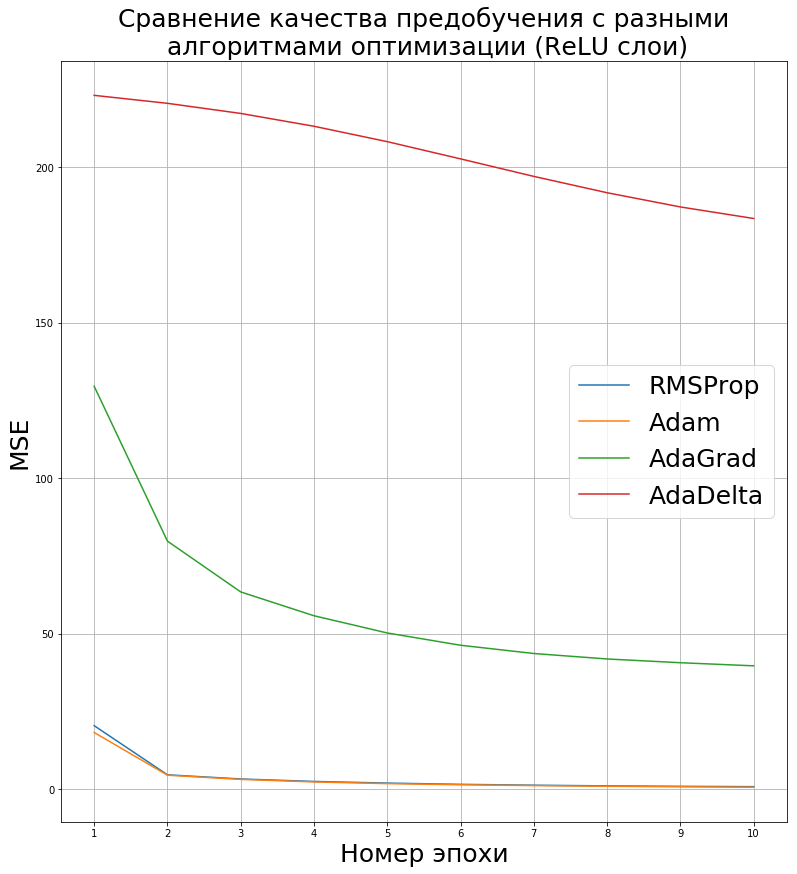

In [7]:
losses_df = pd.read_csv('logs/pre_train_data/optimizer_comparison.csv')

ff_network_amatrix_losses = losses_df['rmsprop'][:10]
ff_network_amatrix_adam_losses = losses_df['adam'][:10]
ff_network_amatrix_adagrad_losses = losses_df['adagrad'][:10]
ff_network_amatrix_adadelta_losses = losses_df['adadelta'][:10]

x = range(1, 11)
fsize = 25
plt.figure(figsize=(13, 14))
plt.plot(x, ff_network_amatrix_losses, label='RMSProp')
plt.plot(x, ff_network_amatrix_adam_losses, label='Adam')
plt.plot(x, ff_network_amatrix_adagrad_losses, label='AdaGrad')
plt.plot(x, ff_network_amatrix_adadelta_losses, label='AdaDelta')
plt.legend(prop={'size': fsize})
plt.xlabel('Номер эпохи', fontsize=fsize)
plt.xticks(x)
plt.grid()
plt.ylabel('MSE', fontsize=fsize)
plt.title('Сравнение качества предобучения с разными\n алгоритмами оптимизации (ReLU слои)', fontsize=fsize)
plt.show()

In [2]:
tf.reset_default_graph()
ff_network_tanh_amatrix = FFNetworkAmatrix(10, activation='tanh')
ff_network_tanh_amatrix_adam = FFNetworkAmatrix(10, activation='tanh', optimizer='adam')
ff_network_tanh_amatrix_adagrad = FFNetworkAmatrix(10, activation='tanh', optimizer='adagrad')
ff_network_tanh_amatrix_adadelta = FFNetworkAmatrix(10, activation='tanh', optimizer='adadelta')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

NameError: name 'tf' is not defined

In [45]:
ff_network_tanh_amatrix_losses = ff_network_tanh_amatrix.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 18.84966305246183
Epoch 1... loss: 2.45752388508824
Epoch 2... loss: 1.463543187501341
Epoch 3... loss: 1.0098030265142608
Epoch 4... loss: 0.7571165459982462
Epoch 5... loss: 0.5998193318164343
Epoch 6... loss: 0.49711272623371905
Epoch 7... loss: 0.4265700919408413
Epoch 8... loss: 0.3756035615897314
Epoch 9... loss: 0.33703799223535824


In [46]:
ff_network_tanh_amatrix.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_tanh_64_64'

In [47]:
ff_network_tanh_amatrix_adam_losses = ff_network_tanh_amatrix_adam.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 20.022885224575184
Epoch 1... loss: 2.188629159169124
Epoch 2... loss: 1.1706813584402844
Epoch 3... loss: 0.7619433470494429
Epoch 4... loss: 0.5492963327143665
Epoch 5... loss: 0.42163002784439374
Epoch 6... loss: 0.34204116490900544
Epoch 7... loss: 0.2900665131195185
Epoch 8... loss: 0.2537400776662501
Epoch 9... loss: 0.22617352314643163


In [48]:
ff_network_tanh_amatrix_adam.save(sess)

'../tf_models/dqn_adam_amatrix_ff_tanh_64_64'

In [50]:
ff_network_tanh_amatrix_adagrad_losses = ff_network_tanh_amatrix_adagrad.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 149.6334080724501
Epoch 1... loss: 114.1964033227468
Epoch 2... loss: 99.08177573607249
Epoch 3... loss: 89.31521609456499
Epoch 4... loss: 81.8709168206323
Epoch 5... loss: 75.90880427659673
Epoch 6... loss: 71.1963441228292
Epoch 7... loss: 67.29120818400808
Epoch 8... loss: 64.00484463171753
Epoch 9... loss: 61.18513347375857


In [51]:
ff_network_tanh_amatrix_adagrad.save(sess)

'../tf_models/dqn_adagrad_amatrix_ff_tanh_64_64'

In [52]:
ff_network_tanh_amatrix_adadelta_losses = ff_network_tanh_amatrix_adadelta.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 224.6652748394237
Epoch 1... loss: 216.3212846101709
Epoch 2... loss: 209.37164132414458
Epoch 3... loss: 203.91158543602447
Epoch 4... loss: 199.6533976439838
Epoch 5... loss: 196.26813822250884
Epoch 6... loss: 193.4874666238026
Epoch 7... loss: 191.11470282353486
Epoch 8... loss: 189.01284978211777
Epoch 9... loss: 187.0857596382212


In [53]:
ff_network_tanh_amatrix_adadelta.save(sess)

'../tf_models/dqn_adadelta_amatrix_ff_tanh_64_64'

In [54]:
losses_tanh = np.array([ff_network_tanh_amatrix_losses, ff_network_tanh_amatrix_adam_losses,
                        ff_network_tanh_amatrix_adagrad_losses, ff_network_tanh_amatrix_adadelta_losses]).transpose()
losses_tanh_df = pd.DataFrame(data=losses_tanh, columns=['rmsprop', 'adam', 'adagrad', 'adadelta'])
losses_tanh_df.to_csv('logs/pre_train_data/optimizer_comparison_tanh.csv')

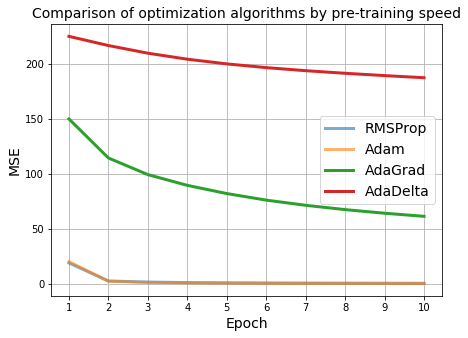

<Figure size 432x288 with 0 Axes>

In [5]:
color_c = cycler('color', ['k'])
style_c = cycler('linestyle', ['-', '--', ':', '-.'])
markr_c = cycler('marker', ['', '.', 'o'])
c_cms = color_c * markr_c * style_c

losses_tanh_df = pd.read_csv('logs/pre_train_data/optimizer_comparison_tanh.csv')

ff_network_tanh_amatrix_losses = losses_tanh_df['rmsprop']
ff_network_tanh_amatrix_adam_losses = losses_tanh_df['adam']
ff_network_tanh_amatrix_adagrad_losses = losses_tanh_df['adagrad']
ff_network_tanh_amatrix_adadelta_losses = losses_tanh_df['adadelta']

x = range(1, 11)
fsize = 14
ticksize = 10
lw=3
f = plt.figure(figsize=(7, 5))
plt.plot(x, ff_network_tanh_amatrix_losses, label='RMSProp', linewidth=lw, alpha=0.6)#, color='k', linestyle='-')
plt.plot(x, ff_network_tanh_amatrix_adam_losses, label='Adam', linewidth=lw, alpha=0.6)#, color='k', linestyle='--')
plt.plot(x, ff_network_tanh_amatrix_adagrad_losses, label='AdaGrad', linewidth=lw)#, color='k', linestyle=':')
plt.plot(x, ff_network_tanh_amatrix_adadelta_losses, label='AdaDelta', linewidth=lw)#, color='k', linestyle='-.')
plt.legend(prop={'size': 14})
plt.xlabel('Epoch', fontsize=fsize)
plt.xticks(x)
plt.rc('xtick', labelsize=ticksize)
plt.rc('ytick', labelsize=ticksize)
plt.grid()
plt.ylabel('MSE', fontsize=fsize)
plt.title('Comparison of optimization algorithms by pre-training speed', fontsize=fsize)
plt.show()

plt.savefig("opt-algos-pre-training-comparison.pdf", bbox_inches='tight')

In [25]:
tf.reset_default_graph()
ff_network_sigmoid_amatrix = FFNetworkAmatrix(10, activation='sigmoid')
ff_network_sigmoid_amatrix_adam = FFNetworkAmatrix(10, activation='sigmoid', optimizer='adam')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [28]:
ff_network_sigmoid_amatrix_losses = ff_network_sigmoid_amatrix.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 48.12509211832228
Epoch 1... loss: 5.840886983601048
Epoch 2... loss: 3.2665749973264235
Epoch 3... loss: 2.1980364923166147
Epoch 4... loss: 1.6159512516146732
Epoch 5... loss: 1.2481771640055497
Epoch 6... loss: 0.9968086905863093
Epoch 7... loss: 0.8224211112067171
Epoch 8... loss: 0.6923834301893474
Epoch 9... loss: 0.5906389240717693


In [29]:
ff_network_sigmoid_amatrix.save(sess)

'../tf_models/dqn_rmsprop_amatrix_ff_sigmoid_64_64'

In [30]:
ff_network_sigmoid_amatrix_adam_losses = ff_network_sigmoid_amatrix_adam.preTrain(sess, shuffle(data), epochs=10)

Epoch 0... loss: 47.27875211179099
Epoch 1... loss: 5.190331884243369
Epoch 2... loss: 2.943751434237487
Epoch 3... loss: 1.8905661246062084
Epoch 4... loss: 1.275770114409496
Epoch 5... loss: 0.9274750830245272
Epoch 6... loss: 0.7111772563240895
Epoch 7... loss: 0.5640053773868151
Epoch 8... loss: 0.4592344688854956
Epoch 9... loss: 0.3820924540439185


In [31]:
ff_network_sigmoid_amatrix_adam.save(sess)

'../tf_models/dqn_adam_amatrix_ff_sigmoid_64_64'

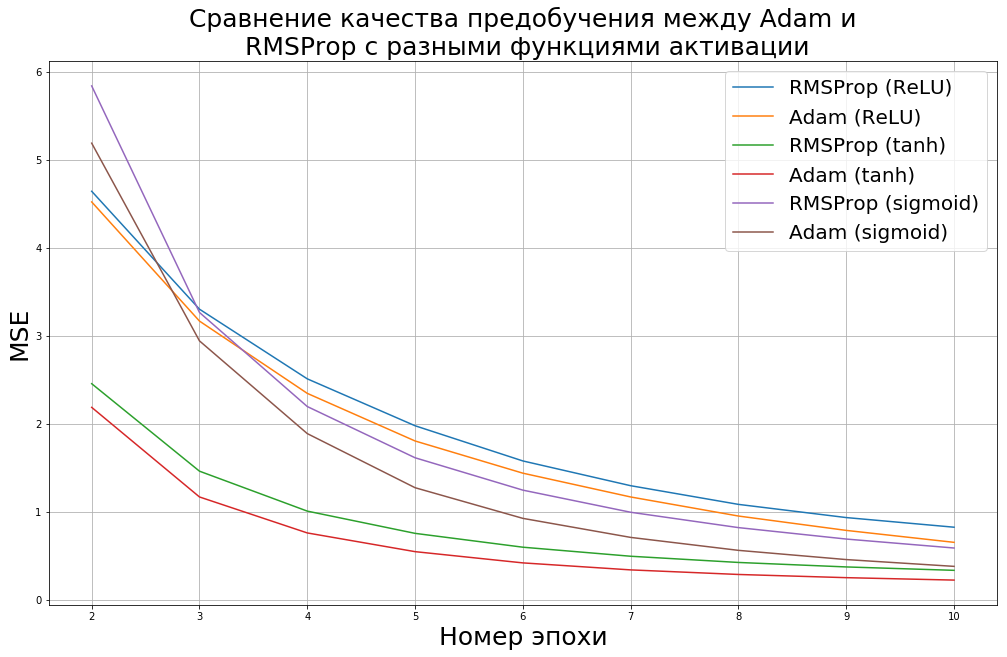

In [33]:
x = range(2, 11)

plt.figure(figsize=(17, 10))
fsize = 25

plt.plot(x, ff_network_amatrix_losses[1:10], label='RMSProp (ReLU)')
plt.plot(x, ff_network_amatrix_adam_losses[1:10], label='Adam (ReLU)')
plt.plot(x, ff_network_tanh_amatrix_losses[1:], label='RMSProp (tanh)')
plt.plot(x, ff_network_tanh_amatrix_adam_losses[1:], label='Adam (tanh)')
plt.plot(x, ff_network_sigmoid_amatrix_losses[1:], label='RMSProp (sigmoid)')
plt.plot(x, ff_network_sigmoid_amatrix_adam_losses[1:], label='Adam (sigmoid)')
plt.legend(prop={'size': 20})
plt.xlabel('Номер эпохи', fontsize=fsize)
plt.xticks(x)
plt.grid()
plt.ylabel('MSE', fontsize=fsize)
plt.title('Сравнение качества предобучения между Adam и\n RMSProp с разными функциями активации', fontsize=fsize)
plt.show()

# Рекуррентые сети

## Предобучение по наблюдениям ноды

In [22]:
tf.reset_default_graph()
rnn_network_amatrix = RQNetworkAmatrix(10, ff_activation='tanh')
rnn_network_gru_amatrix = RQNetworkAmatrix(10, ff_activation='tanh', cell_type='gru')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [18]:
rnn_network_amatrix_losses = rnn_network_amatrix.preTrain(sess, data, epochs=20, episode_length=8,
                                                          shuffle_eps=True)

Epoch 0... loss: 22.700221331989134
Epoch 1... loss: 10.436203931558397
Epoch 2... loss: 7.34969959951009
Epoch 3... loss: 5.652958536798937
Epoch 4... loss: 4.819467243110423
Epoch 5... loss: 3.7777842119126834
Epoch 6... loss: 3.0046638865995536
Epoch 7... loss: 2.5072981469347098
Epoch 8... loss: 2.290658500411371
Epoch 9... loss: 2.261133800110553
Epoch 10... loss: 1.8341901319892149
Epoch 11... loss: 1.886589976742574
Epoch 12... loss: 1.6760508062580588
Epoch 13... loss: 1.6055046764686132
Epoch 14... loss: 1.3673140661884235
Epoch 15... loss: 1.476091236526539
Epoch 16... loss: 1.3376008899442147
Epoch 17... loss: 1.237031949761027
Epoch 18... loss: 1.0866884822853795
Epoch 19... loss: 1.0546218610201477


In [19]:
rnn_network_amatrix.save(sess)

'../tf_models/dqn_rmsprop_amatrix_lstm_tanh_64-tanh_64'

In [24]:
%%time
rnn_network_gru_amatrix_losses = rnn_network_gru_amatrix.preTrain(sess, data, epochs=20, episode_length=8,
                                                                  shuffle_eps=True)

Epoch 0... loss: 17.32520866877974
Epoch 1... loss: 6.6033907899090405
Epoch 2... loss: 5.535827183954417
Epoch 3... loss: 4.724957161532681
Epoch 4... loss: 4.056318650203591
Epoch 5... loss: 4.67689899464117
Epoch 6... loss: 4.320189676294365
Epoch 7... loss: 4.132425909925949
Epoch 8... loss: 4.129385792202288
Epoch 9... loss: 3.5509402205704723
Epoch 10... loss: 3.1280606219716067
Epoch 11... loss: 3.7581393460414403
Epoch 12... loss: 3.340589578295507
Epoch 13... loss: 3.267126967894157
Epoch 14... loss: 3.2062551382489763
Epoch 15... loss: 3.1697990393006847
Epoch 16... loss: 3.084718013292355
Epoch 17... loss: 2.733407387599107
Epoch 18... loss: 2.5626299205125744
Epoch 19... loss: 2.4841605547119285
CPU times: user 1h 40min 42s, sys: 8min 46s, total: 1h 49min 28s
Wall time: 51min 49s


In [25]:
rnn_network_gru_amatrix.save(sess)

'../tf_models/dqn_rmsprop_amatrix_gru_tanh_64-tanh_64'

## Предобучение вдоль пути пакета

In [8]:
tf.reset_default_graph()
rnn_network_amatrix_per_pkg = RQNetworkAmatrix(10, ff_activation='tanh', scope='per_pkg')
#rnn_network_gru_amatrix_per_pkg = RQNetworkAmatrix(10, ff_activation='tanh', cell_type='gru', scope='per_pkg')

init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [9]:
%%time
rnn_network_amatrix_per_pkg_losses = rnn_network_amatrix_per_pkg.preTrain(sess, data, epochs=5,
                                                                          episode_col='pkg_id', shuffle_eps=True)

Epoch 0... loss: 7.722103755181913
Epoch 1... loss: 1.3163191965565086
Epoch 2... loss: 0.7889296287332017
Epoch 3... loss: 0.5537869784601462
Epoch 4... loss: 0.44370705402914723
CPU times: user 47min 57s, sys: 2min 40s, total: 50min 37s
Wall time: 31min 41s


In [10]:
rnn_network_amatrix_per_pkg.save(sess)

'../tf_models/dqn_rmsprop_amatrix_per_pkg_lstm_tanh_64-tanh_64'

# Конвейеры

In [56]:
tf.reset_default_graph()
conveyor_network = FFNetworkAddFlatAmatrix(16, scope='conveyor_test', flat_inputs={'work_status':'graph_size'})
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [57]:
data_conv = pd.read_csv('logs/data_conveyor_gen_test2.csv', names=get_conveyor_data_cols(16))

In [58]:
data_conv.head()

,dst,addr,time,pkg_id,neighbors_0,neighbors_1,neighbors_2,neighbors_3,neighbors_4,neighbors_5,...,predict_6,predict_7,predict_8,predict_9,predict_10,predict_11,predict_12,predict_13,predict_14,predict_15
0,13.0,2.0,10.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
1,13.0,3.0,20.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1000000.0,-30.0,-1000000.0,-1000000.0,-1000000.0,-10.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
2,13.0,11.0,30.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-0.0,-1000000.0,-1000000.0
3,15.0,0.0,20.0,2.0,0.0,0.0,0.0,0.0,0.0,1.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
4,15.0,5.0,30.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,-1000000.0,-1000000.0,-20.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0


In [59]:
conveyor_network.makeInputFromData(data_conv)

{'addr': array([  2.,   3.,  11., ...,  10.,   9.,  12.]),
 'amatrix': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.]]),
 'dst': array([ 13.,  13.,  13., ...,  14.,  14.,  14.]),
 'neighbors': array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        ..., 
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.]]),
 'work_status': array([[ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  1., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  1.,  0.,  0.],
        ..., 
        [ 1.,  0.,  0., ...,  0.,  0.,  1.],
        [ 0.,  0.,  0., ...,  0.,  1.,  0.],
        [ 0.,  0.,  0., ...,  1.,

In [60]:
conveyor_network_amatrix_losses = conveyor_network.preTrain(sess, shuffle(data_conv), epochs=10)

Epoch 0... loss: 44.434306599735436
Epoch 1... loss: 25.684749391343857
Epoch 2... loss: 10.443390450446435
Epoch 3... loss: 4.235161440045226
Epoch 4... loss: 2.426896776249206
Epoch 5... loss: 1.431958681617687
Epoch 6... loss: 0.9349156933672288
Epoch 7... loss: 0.604355698707057
Epoch 8... loss: 0.4350917832134596
Epoch 9... loss: 0.3487723258390925


In [61]:
conveyor_network.save(sess)

'../tf_models/dqn_rmsprop_amatrix_work_status16_conveyor_test_ff_relu_64_64'

In [19]:
tf.reset_default_graph()
conveyor_network_ng_no_inp = FFNetwork(22, scope='conveyor_test_ng')
conveyor_network_ng = FFNetworkAddFlatAmatrix(22, scope='conveyor_test_ng', flat_inputs={'work_status':'graph_size'})
conveyor_rnn_ng = RQNetworkAddFlatAmatrix(22, ff_activation='tanh', 
                                          flat_inputs={'work_status':'graph_size'},
                                          scope='conveyor_test_ng') 
conveyor_rnn_pp_ng = RQNetworkAddFlatAmatrix(22, ff_activation='tanh', 
                                             flat_inputs={'work_status':'graph_size'},
                                             scope='conveyor_test_ng_per_pkg')
init = tf.global_variables_initializer()
sess = tf.Session()
sess.run(init)

In [20]:
data_conv_ng = pd.read_csv('logs/data_conveyor_gen_energy_test.csv', names=['belt_id']+get_conveyor_data_cols(22))

In [21]:
data_conv_ng.head()

,belt_id,dst,addr,time,pkg_id,neighbors_0,neighbors_1,neighbors_2,neighbors_3,neighbors_4,...,predict_12,predict_13,predict_14,predict_15,predict_16,predict_17,predict_18,predict_19,predict_20,predict_21
0,0.0,18.0,0.0,10.0,1.0,0.0,0.0,1.0,0.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
1,0.0,18.0,2.0,20.0,1.0,0.0,0.0,0.0,1.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
2,0.0,18.0,3.0,30.0,1.0,0.0,0.0,0.0,0.0,1.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
3,0.0,18.0,4.0,40.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0
4,2.0,18.0,7.0,50.0,1.0,0.0,0.0,0.0,0.0,0.0,...,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0,-1000000.0


In [23]:
conveyor_network_ng_no_inp_losses = conveyor_network_ng_no_inp.preTrain(sess, shuffle(data_conv_ng), epochs=5)

Epoch 0... loss: 0.20001798869066295
Epoch 1... loss: 0.07961566418054558
Epoch 2... loss: 0.04483793437747019
Epoch 3... loss: 0.03315841511690191
Epoch 4... loss: 0.028280684484967164


In [24]:
conveyor_network_ng_no_inp.save(sess)

'../tf_models/dqn_rmsprop_conveyor_test_ng_ff_relu_64_64'

In [16]:
conveyor_network_ng_losses = conveyor_network_ng.preTrain(sess, shuffle(data_conv_ng), epochs=10)

Epoch 0... loss: 43.51222013745989
Epoch 1... loss: 19.68220436459496
Epoch 2... loss: 6.572651724588304
Epoch 3... loss: 3.9815329358691263
Epoch 4... loss: 3.135512413865044
Epoch 5... loss: 2.489451770839237
Epoch 6... loss: 1.872145863657906
Epoch 7... loss: 1.2366749139059157
Epoch 8... loss: 0.7022510056694349
Epoch 9... loss: 0.3865967393631027


In [12]:
conveyor_network_ng.save(sess)

'../tf_models/dqn_rmsprop_amatrix_work_status22_conveyor_test_ng_ff_relu_64_64'

In [16]:
conveyor_rnn_ng_losses = conveyor_rnn_ng.preTrain(sess, data_conv_ng, epochs=1, episode_length=8,
                                                  episode_col='belt_id', shuffle_eps=True)

Epoch 0... loss: 0.40214842979673293


In [70]:
conveyor_rnn_ng.save(sess)

'../tf_models/dqn_rmsprop_amatrix_work_status22_conveyor_test_ng_lstm_tanh_64-tanh_64'

In [10]:
conveyor_rnn_pp_ng_losses = conveyor_rnn_pp_ng.preTrain(sess, data_conv_ng, epochs=3,
                                                        episode_col='pkg_id', shuffle_eps=True)

Epoch 0... loss: 15.810810847997665
Epoch 1... loss: 1.9607475604424254
Epoch 2... loss: 0.32505450949887743


In [11]:
conveyor_rnn_pp_ng.save(sess)

'../tf_models/dqn_rmsprop_amatrix_work_status22_conveyor_test_ng_per_pkg_lstm_tanh_64-tanh_64'